In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-09-12 06:40:43--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-09-12 06:40:44 (7.27 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
dir = r'/content/'
words = open(dir+'/names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
# Build Vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

27


In [ ]:
#create training set (x,y)

block_size = 8 # berapa karakter pendahulu yang dipakai untuk memprediksi karakter setelahnya
vocab_size = 27

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context) , ' ---> ',itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [ ]:
#Splitting Data Train, Dev, Test (80%, 10%, 10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9* len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(X_tr[:10],Y_tr[:10]):
    print(''.join(itos[ix.item()] for ix in x) , ' --> ' , itos[y.item()])

........  -->  y
.......y  -->  u
......yu  -->  h
.....yuh  -->  e
....yuhe  -->  n
...yuhen  -->  g
..yuheng  -->  .
........  -->  d
.......d  -->  i
......di  -->  o


In [ ]:
print(X_tr.shape,Y_tr.shape)
print(X_dev.shape,Y_dev.shape)
print(X_te.shape,Y_te.shape)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:

class Linear:

    def __init__(self,fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]



class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


class FlattenConsecutive:
    '''
    FlattenConsecutive : digunakan untuk implementasi wavenet
    n : jumlah consecutive element
        misalnya 2 untuk bigram, 4 untuk fourgram dst.

    '''
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B , T//self.n , C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
# --> want to have the same parameters when the block size was 8

block_size = 2

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [ ]:
batch_size = 32
max_steps = 200000
loss_track = []

In [ ]:
for step in range(max_steps):

    # construct mini batch
    ix = torch.randint(0,X_tr.shape[0],(batch_size,))
    Xb, Yb = X_tr[ix], Y_tr[ix]


    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)


    #backward pass
    #set zero grad on parameters
    for p in parameters:
        p.grad = None
    #backward
    loss.backward()

    #update parameters
    learning_rate = 0.1 if step < 150000 else 0.01
    for p in parameters:
        # print(p.grad)
        p.data += -(p.grad * learning_rate)

    if step% 10_000 == 0:
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_track.append(loss.log10().item())



      0/ 200000: 3.2973
  10000/ 200000: 2.1628
  20000/ 200000: 2.4159
  30000/ 200000: 2.0838
  40000/ 200000: 1.7965
  50000/ 200000: 2.0641
  60000/ 200000: 1.8672
  70000/ 200000: 2.3448
  80000/ 200000: 2.7899
  90000/ 200000: 2.0918
 100000/ 200000: 2.1516
 110000/ 200000: 2.1048
 120000/ 200000: 2.3832
 130000/ 200000: 1.8078
 140000/ 200000: 2.0962
 150000/ 200000: 2.0116
 160000/ 200000: 1.9724
 170000/ 200000: 2.3117
 180000/ 200000: 1.9720
 190000/ 200000: 1.6058


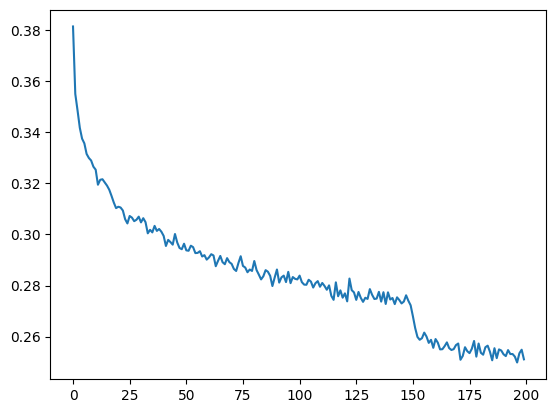

In [ ]:
plt.plot(torch.tensor(loss_track).view(-1, 1000).mean(1))

In [ ]:
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {'train' : (X_tr, Y_tr),
           'val' : (X_dev, Y_dev),
           'test' : (X_te, Y_te)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.7688896656036377
val 1.989289402961731
test 1.9921014308929443


### Performance Log :
1. original (3 character context + 200 hidden neurons, 12K params)
    - train 2.0583250522613525
    - val 2.1065292358398438
    - test 2.104623556137085
2. Modified context length (8 character context + 200 hidden neurons, 22K params)
    - train 1.921517252922058
    - val 2.029385805130005
    - test 2.030794382095337
3. Wavenet (10 emb neurons, 68 hidden neurons, 22K params)
    - train 1.9124091863632202
    - val 2.018151044845581
    - test 2.0149097442626953

3. Wavenet (24 emb neurons, 128 hidden neurons, 22K params)
    - train 1.7688896656036377
    - val 1.989289402961731
    - test 1.9921014308929443

In [ ]:
#Geenerate sample from model
with torch.no_grad():
    for i in range(20):
        out = []
        context = [0] * 8
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples = 1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(''.join(itos[i] for i in out))

darorio.
gracele.
kenedop.
tashra.
dechasis.
sias.
aiden.
camugan.
deilia.
charlie.
aylen.
kayai.
xzaiva.
keletti.
jenni.
jakyn.
soneston.
anaiaja.
caetriondra.
dillookar.


# Logika Bagaimana Proses Wavenet

In [ ]:
a = torch.arange(0,80).view((1,8,10))
a

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
         [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
         [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
         [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]]])

In [ ]:
a[:, ::2, :]

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
         [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]])

In [ ]:
a[:, 1::2, :]

tensor([[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
         [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
         [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]]])

In [ ]:
torch.cat((a[:, ::2] , a[:, ::2]), dim = 2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,
           7,  8,  9],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 25, 26,
          27, 28, 29],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 40, 41, 42, 43, 44, 45, 46,
          47, 48, 49],
         [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 60, 61, 62, 63, 64, 65, 66,
          67, 68, 69]]])

In [ ]:
a.view(1,80)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79]])

dimensi diubah menjadi (1,4,20) untuk membuat sebuah dimensi tensor yang isi elemennya 20 dimana merupakan 2 pasang karakter,
4 merupakan jumlah pasangan karakter yang tercipta.

In [ ]:
a.view(1,4,20)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
          37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
          57, 58, 59],
         [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
          77, 78, 79]]])

In [ ]:
w = torch.ones(size = (80,10), dtype=int)
w.shape

torch.Size([80, 10])

In [ ]:
a.view(1,80) @ w

tensor([[3160, 3160, 3160, 3160, 3160, 3160, 3160, 3160, 3160, 3160]])

In [ ]:
w = torch.ones(size = (20,10), dtype=int)
w.shape

torch.Size([20, 10])

In [ ]:
a.view(1,4,20) @ w

tensor([[[ 190,  190,  190,  190,  190,  190,  190,  190,  190,  190],
         [ 590,  590,  590,  590,  590,  590,  590,  590,  590,  590],
         [ 990,  990,  990,  990,  990,  990,  990,  990,  990,  990],
         [1390, 1390, 1390, 1390, 1390, 1390, 1390, 1390, 1390, 1390]]])

ketika dilakukan operasi dot product ke tensor w, operasinya hanya dilakukan pada dimensi terakhir, atau seakan2 terjadi 4 kali operasi perkalian matrix secara paralel untuk setiap kelompok pasangan karakter

In [ ]:
a.view(1,4,20)[0][1] @ w

tensor([590, 590, 590, 590, 590, 590, 590, 590, 590, 590])